In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33429 instead
  f"Port {expected} is already in use.\n"


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33429/status,
Dashboard: /proxy/33429/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39629,Workers: 4
Dashboard: /proxy/33429/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.149:40211,Total threads: 4
Dashboard: /proxy/32965/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:34265,


In [4]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [5]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [6]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker


### Load functions

In [7]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName


def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [8]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [9]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [10]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [11]:
timeRange = [8005, 8137]
datelist = np.array(range(timeRange[0],timeRange[1],4))


In [12]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

In [13]:

# datelist = np.array(range(timeRange[0],timeRange[1],4))

# filelist=[hisOSSEFilePath1+prefixAnalysis+''+str(datelist[0])+'.nc']
# for dates in datelist[1:]:
#     filenameToAppend=hisOSSEFilePath1+prefixAnalysis+''+str(dates)+'.nc'
#     filelist.append(filenameToAppend)

# print(filelist)

In [14]:
def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist


filelistTruth=generateFileList(hisTruthFilePath,prefixTruth,datelist)
filelist_SSHSST=generateFileList(hisOSSEFilePath1,prefixAnalysis,datelist)
filelist_SSHSST_XBT=generateFileList(hisOSSEFilePath2,prefixAnalysis,datelist)
filelist_SSHSST_XBT_N=generateFileList(hisOSSEFilePath3,prefixAnalysis,datelist)
filelist_SSHSST_XBT_S=generateFileList(hisOSSEFilePath4,prefixAnalysis,datelist)

truth=loadOverlappedNetcdfFileList(hisTruthFilePath,prefixTruth,filelist=filelistTruth,overlapDays=7)
OSSE_SSHSST=loadOSSEFileList(hisOSSEFilePath1,prefixAnalysis, filelist=filelist_SSHSST,overlapDays=7)
OSSE_SSHSST_XBT=loadOSSEFileList(hisOSSEFilePath2,prefixAnalysis, filelist=filelist_SSHSST_XBT,overlapDays=7)
OSSE_SSHSST_XBT_N=loadOSSEFileList(hisOSSEFilePath3,prefixAnalysis, filelist=filelist_SSHSST_XBT_N,overlapDays=7)
OSSE_SSHSST_XBT_S=loadOSSEFileList(hisOSSEFilePath4,prefixAnalysis, filelist=filelist_SSHSST_XBT_S,overlapDays=7)

loaded from /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08005.nc to /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08133.nc
loaded from /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08005.nc to /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08133.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08133.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08133.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/roms_fwd_outer1_08133.nc


In [15]:
# process into more useful format
truth = processROMSGrid(truth)
OSSE_SSHSST=processROMSGrid(OSSE_SSHSST)
OSSE_SSHSST_XBT=processROMSGrid(OSSE_SSHSST_XBT)
OSSE_SSHSST_XBT_N=processROMSGrid(OSSE_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S=processROMSGrid(OSSE_SSHSST_XBT_S)

In [16]:
grid = makeROMSGridObject(truth)

In [17]:
# outline xbt array region

XBTboxlon = truth.lon_rho.isel(eta_rho=256,xi_rho=slice(74,271)).values
XBTboxdep0 = truth.z_rho.isel(eta_rho=256,xi_rho=slice(74,271),s_rho=-1,ocean_time=0).values
XBTboxdep1 = truth.z_rho.isel(eta_rho=256,xi_rho=slice(74,271),s_rho=0,ocean_time=0).values
XBTboxdep2 = -900
XBTboxdep1[XBTboxdep1<XBTboxdep2] = XBTboxdep2
boxLon=np.hstack([np.concatenate([XBTboxlon,np.flip(XBTboxlon,0)]),XBTboxlon[0]])
boxDep=np.hstack([np.concatenate([XBTboxdep0,np.flip(XBTboxdep1,0)]),XBTboxdep0[0]])

# fig,ax=plt.subplots(1)
# ax.plot(boxLon,boxDep)

In [18]:
# ## test vertical transect

# def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol])
#     ax.set_facecolor('xkcd:grey')
#     im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.05,.09, .8, .8),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     ax.set_ylim([-2000,0])
#     fig.colorbar(im, cax=cax)
#     ax.grid()
#     return ax

# def addSubplot_VerticalTransect_contourf(X,Y,input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol])
#     ax.set_facecolor('xkcd:grey')
#     im = ax.contourf(X,Y,input,levels,**pcol_kwargs)
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.82,.09, .8, .8),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     return ax




# gs = gridspec.GridSpec(nrows=5,ncols=3,wspace=0.05, hspace=0.05)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[15,22.5])
# ax = None

# # reqd for contourf plot
# levels=np.arange(-100,110,25)


# # add plots
# ## top row
# etaTransect=300
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# ax1 = addSubplot_VerticalTransect(x,y,z,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal','vmin':5,'vmax':25})#, ax1[0].set_title('u (m/s)')
# ax1.text(0.5, 1.1, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax1.transAxes)
# ax1.text(-.2, .5, 'Truth mean state',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax1.transAxes)
# ax1.set_xticklabels([])
# ax1.plot(boxLon,boxDep,color='0.8',linewidth=1)
# etaTransect=220
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# ax2 = addSubplot_VerticalTransect(x,y,z,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.thermal','vmin':5,'vmax':25})#, ax1[0].set_title('u (m/s)')
# ax2.text(0.5, 1.1, '$\sim32^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax2.transAxes)
# ax2.set_xticklabels([])
# ax2.set_yticklabels([])
# etaTransect=140
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# ax3 = addSubplot_VerticalTransect(x,y,z,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.thermal','vmin':5,'vmax':25})#, ax1[0].set_title('u (m/s)')
# ax3.text(0.5, 1.1, '$\sim36^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax3.transAxes)
# ax3.set_xticklabels([])
# ax3.set_yticklabels([])
# #row2
# etaTransect=300
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z=(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
# ax4 = addSubplot_VerticalTransect(x,y,z,gs,1,0,'d',pcol_kwargs={'vmin':0,'vmax':2})#, ax1[0].set_title('u (m/s)')
# ax4.text(-.2, .5, 'SSH+SST rms',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax4.transAxes)
# ax4.set_xticklabels([])
# etaTransect=220
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z=(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
# ax5 = addSubplot_VerticalTransect(x,y,z,gs,1,1,'e',pcol_kwargs={'vmin':0,'vmax':2})#, ax1[0].set_title('u (m/s)')
# ax5.set_xticklabels([])
# ax5.set_yticklabels([])
# etaTransect=140
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z=(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
# ax6 = addSubplot_VerticalTransect(x,y,z,gs,1,2,'f',pcol_kwargs={'vmin':0,'vmax':2})#, ax1[0].set_title('u (m/s)')
# ax6.set_xticklabels([])
# ax6.set_yticklabels([])
# #row 3
# etaTransect=300
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z= ((((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2) - (((OSSE_SSHSST_XBT_N.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2))/(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)*100
# ax7 = addSubplot_VerticalTransect_contourf(x,y,z,levels,gs,2,0,'g',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
# ax7.text(-.2, .5, 'XBT-N %I',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
# ax7.set_xticklabels([])
# etaTransect=220
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z= ((((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2) - (((OSSE_SSHSST_XBT_N.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2))/(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)*100
# ax8 = addSubplot_VerticalTransect_contourf(x,y,z,levels,gs,2,1,'h',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
# ax8.set_xticklabels([])
# ax8.set_yticklabels([])
# etaTransect=140
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z= ((((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2) - (((OSSE_SSHSST_XBT_N.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2))/(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)*100
# ax9 = addSubplot_VerticalTransect_contourf(x,y,z,levels,gs,2,2,'i',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
# ax9.set_xticklabels([])
# ax9.set_yticklabels([])
# #row 4
# etaTransect=300
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z= ((((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2) - (((OSSE_SSHSST_XBT_S.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2))/(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)*100
# ax10 = addSubplot_VerticalTransect_contourf(x,y,z,levels,gs,3,0,'j',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
# ax10.text(-.2, .5, 'XBT-S %I',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax10.transAxes)
# ax10.set_xticklabels([])
# etaTransect=220
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z= ((((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2) - (((OSSE_SSHSST_XBT_S.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2))/(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)*100
# ax11 = addSubplot_VerticalTransect_contourf(x,y,z,levels,gs,3,1,'k',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
# ax11.set_xticklabels([])
# ax11.set_yticklabels([])
# etaTransect=140
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z= ((((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2) - (((OSSE_SSHSST_XBT_S.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2))/(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)*100
# ax12 = addSubplot_VerticalTransect_contourf(x,y,z,levels,gs,3,2,'l',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
# ax12.set_xticklabels([])
# ax12.set_yticklabels([])
# #row 5
# etaTransect=300
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z= ((((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2) - (((OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2))/(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)*100
# ax13 = addSubplot_VerticalTransect_contourf(x,y,z,levels,gs,4,0,'m',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
# ax13.text(-.2, .5, 'XBT %I',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax13.transAxes)
# etaTransect=220
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z= ((((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2) - (((OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2))/(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)*100
# ax14 = addSubplot_VerticalTransect_contourf(x,y,z,levels,gs,4,1,'n',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
# ax14.set_yticklabels([])
# etaTransect=140
# x=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
# y=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
# z= ((((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2) - (((OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2))/(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)*100
# ax15 = addSubplot_VerticalTransect_contourf(x,y,z,levels,gs,4,2,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
# ax15.set_yticklabels([])

In [25]:


etaTransect=300
RMSD_SSHSST_temp_300=(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_N_temp_300=(((OSSE_SSHSST_XBT_N.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_S_temp_300=(((OSSE_SSHSST_XBT_S.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_temp_300=(((OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
etaTransect=220
RMSD_SSHSST_temp_220=(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_N_temp_220=(((OSSE_SSHSST_XBT_N.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_S_temp_220=(((OSSE_SSHSST_XBT_S.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_temp_220=(((OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
etaTransect=140
RMSD_SSHSST_temp_140=(((OSSE_SSHSST.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_N_temp_140=(((OSSE_SSHSST_XBT_N.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_S_temp_140=(((OSSE_SSHSST_XBT_S.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_temp_140=(((OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)


RMSD_SSHSST_temp_300.load(), print('done')
RMSD_SSHSST_XBT_N_temp_300.load(), print('done')
RMSD_SSHSST_XBT_S_temp_300.load(), print('done')
RMSD_SSHSST_XBT_temp_300.load(), print('done')
RMSD_SSHSST_temp_220.load(), print('done')
RMSD_SSHSST_XBT_N_temp_220.load(), print('done')
RMSD_SSHSST_XBT_S_temp_220.load(), print('done')
RMSD_SSHSST_XBT_temp_220.load(), print('done')
RMSD_SSHSST_temp_140.load(), print('done')
RMSD_SSHSST_XBT_N_temp_140.load(), print('done')
RMSD_SSHSST_XBT_S_temp_140.load(), print('done')
RMSD_SSHSST_XBT_temp_140.load(), print('done')

etaTransect=300
I_XBT_N_300= (RMSD_SSHSST_temp_300-RMSD_SSHSST_XBT_N_temp_300)/RMSD_SSHSST_temp_300*100
I_XBT_S_300= (RMSD_SSHSST_temp_300-RMSD_SSHSST_XBT_S_temp_300)/RMSD_SSHSST_temp_300*100
I_XBT_300= (RMSD_SSHSST_temp_300-RMSD_SSHSST_XBT_temp_300)/RMSD_SSHSST_temp_300*100

etaTransect=220
I_XBT_N_220= (RMSD_SSHSST_temp_220-RMSD_SSHSST_XBT_N_temp_220)/RMSD_SSHSST_temp_220*100
I_XBT_S_220= (RMSD_SSHSST_temp_220-RMSD_SSHSST_XBT_S_temp_220)/RMSD_SSHSST_temp_220*100
I_XBT_220= (RMSD_SSHSST_temp_220-RMSD_SSHSST_XBT_temp_220)/RMSD_SSHSST_temp_220*100

etaTransect=140
I_XBT_N_140= (RMSD_SSHSST_temp_140-RMSD_SSHSST_XBT_N_temp_140)/RMSD_SSHSST_temp_140*100
I_XBT_S_140= (RMSD_SSHSST_temp_140-RMSD_SSHSST_XBT_S_temp_140)/RMSD_SSHSST_temp_140*100
I_XBT_140= (RMSD_SSHSST_temp_140-RMSD_SSHSST_XBT_temp_140)/RMSD_SSHSST_temp_140*100

done
done
done
done
done
done
done
done
done
done
done
done


In [43]:
I_XBT_N_300.load(), print('done')
I_XBT_S_300.load(), print('done')
I_XBT_300.load(), print('done')
I_XBT_N_220.load(), print('done')
I_XBT_S_220.load(), print('done')
I_XBT_220.load(), print('done')
I_XBT_N_140.load(), print('done')
I_XBT_S_140.load(), print('done')
I_XBT_140.load(), print('done')

done
done
done
done
done
done
done
done
done


(<xarray.DataArray 'temp' (s_rho: 30, xi_rho: 272)>
 array([[         nan,          nan,          nan, ...,  12.93560542,
          -2.30468463,   6.69029292],
        [         nan,          nan,          nan, ...,  25.79150329,
           3.27566731, -10.06190463],
        [         nan,          nan,          nan, ...,  11.1383236 ,
         -11.66499235, -13.06920883],
        ...,
        [         nan,          nan,          nan, ...,  15.94992164,
         -12.1617299 ,  -5.02425314],
        [         nan,          nan,          nan, ...,  15.58935385,
          -9.97602537,   0.09122592],
        [         nan,          nan,          nan, ...,  14.5109365 ,
         -10.80032221,  -0.05759037]])
 Coordinates:
   * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho  (xi_rho) float64 149.8 149.8 149.8 149.8 ... 159.7 159.8 159.9
     lat_rho  (xi_rho) float64 -32.57 -32.58 -32.59 -32.6 ... -35.58 -35.6 -35.62
 Dimensions without coordinates: xi_r

In [57]:
etaTransect=300
x1=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
y1=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
y1.load(),print('done')
etaTransect=220
x2=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
y2=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
y2.load(),print('done')
etaTransect=140
x3=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
y3=truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time')
y3.load(),print('done')



etaTransect=300
truth_temp_300=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
truth_temp_300.load(),print('done')
etaTransect=220
truth_temp_220=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
truth_temp_220.load(),print('done')
etaTransect=140
truth_temp_140=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
truth_temp_140.load(),print('done')

done
done
done
done
done
done


(<xarray.DataArray 'temp' (s_rho: 30, xi_rho: 272)>
 array([[        nan,         nan,         nan, ...,  0.9929764 ,
          0.9811376 ,  0.9631558 ],
        [        nan,         nan,         nan, ...,  1.001646  ,
          0.99859226,  0.990643  ],
        [        nan,         nan,         nan, ...,  1.0567462 ,
          1.0684184 ,  1.0617903 ],
        ...,
        [        nan,         nan,         nan, ..., 20.75303   ,
         20.753305  , 20.947132  ],
        [        nan,         nan,         nan, ..., 20.770296  ,
         20.764494  , 20.954235  ],
        [        nan,         nan,         nan, ..., 20.799234  ,
         20.788967  , 20.982908  ]], dtype=float32)
 Coordinates:
   * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho  (xi_rho) float64 149.8 149.8 149.8 149.8 ... 159.7 159.8 159.9
     lat_rho  (xi_rho) float64 -32.57 -32.58 -32.59 -32.6 ... -35.58 -35.6 -35.62
 Dimensions without coordinates: xi_rho,
 None)

In [74]:
truth

<xarray.Dataset>
Dimensions:        (boundary: 4, eta_rho: 317, eta_v: 316, ocean_time: 792, s_rho: 30, s_w: 31, tracer: 2, xi_rho: 272, xi_u: 271)
Coordinates: (12/13)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_u          (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_u          (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    ...             ...
    lat_v          (eta_v, xi_rho) float64 dask.array<chunksize=(316, 272), meta=np.ndarray>
    lon_psi        (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_psi        (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-02 ... 2012-04-11T20:0...
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 317, 272), meta=np.ndarray>
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 317, 272), meta=np.ndarray>
Dimensions without coordinates: boundary, eta_rho, eta_v, tracer, xi_rho, xi_u
Data variables: (12/113)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    dz_w           (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 1, 317, 272), meta=np.ndarray>
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 317, 271), meta=np.ndarray>
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 1, 317, 271), meta=np.ndarray>
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 316, 272), meta=np.ndarray>
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 1, 316, 272), meta=np.ndarray>
    dA             (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [84]:
def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output


def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [86]:
calc_depthAverageROMS(I_XBT_140,truth,140).values

array(-0.99030361)

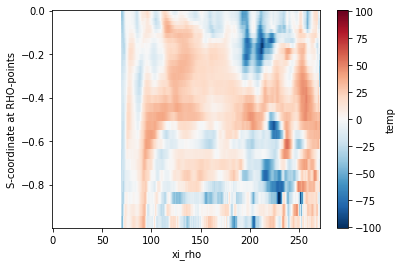

In [92]:
I_XBT_140.plot()

[Text(0, -2000.0, ''),
 Text(0, -1750.0, ''),
 Text(0, -1500.0, ''),
 Text(0, -1250.0, ''),
 Text(0, -1000.0, ''),
 Text(0, -750.0, ''),
 Text(0, -500.0, ''),
 Text(0, -250.0, ''),
 Text(0, 0.0, '')]

<Figure size 432x288 with 0 Axes>

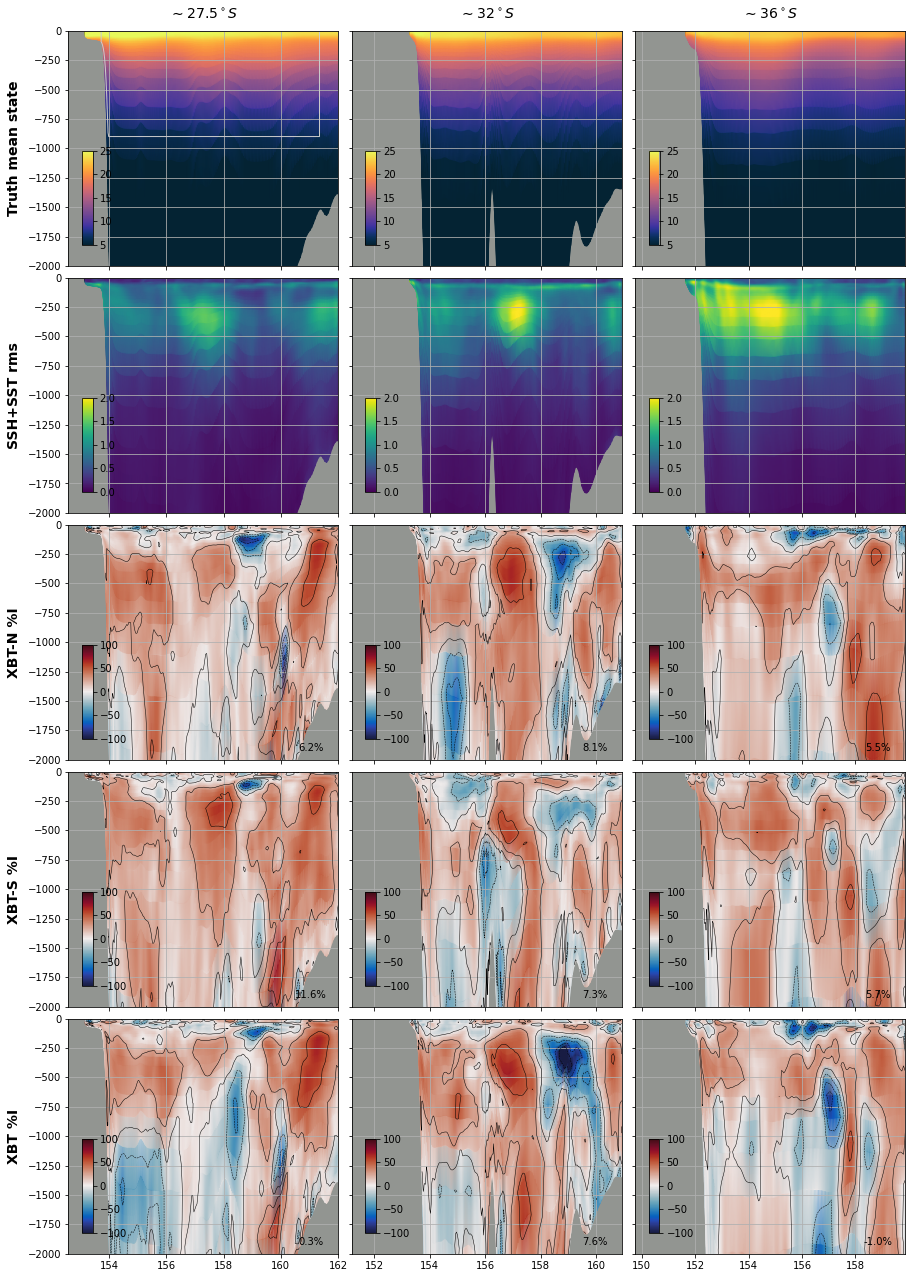

In [95]:
## test vertical transect

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    ax.set_ylim([-2000,0])
    fig.colorbar(im, cax=cax)
    ax.grid()
    return ax

def addSubplot_VerticalTransect_contourf(X,Y,input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.contourf(X,Y,input,levels,**pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    return ax




gs = gridspec.GridSpec(nrows=5,ncols=3,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,22.5])
ax = None

# reqd for contourf plot
levels=np.arange(-100,110,25)



# add plots
## top row
etaTransect=300
ax1 = addSubplot_VerticalTransect(x1,y1,truth_temp_300,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal','vmin':5,'vmax':25})#, ax1[0].set_title('u (m/s)')
ax1.text(0.5, 1.1, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax1.transAxes)
ax1.text(-.2, .5, 'Truth mean state',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax1.transAxes)
ax1.set_xticklabels([])
ax1.plot(boxLon,boxDep,color='0.8',linewidth=1)
etaTransect=220
ax2 = addSubplot_VerticalTransect(x2,y2,truth_temp_220,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.thermal','vmin':5,'vmax':25})#, ax1[0].set_title('u (m/s)')
ax2.text(0.5, 1.1, '$\sim32^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax2.transAxes)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
etaTransect=140
ax3 = addSubplot_VerticalTransect(x3,y3,truth_temp_140,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.thermal','vmin':5,'vmax':25})#, ax1[0].set_title('u (m/s)')
ax3.text(0.5, 1.1, '$\sim36^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax3.transAxes)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
#row2
etaTransect=300
ax4 = addSubplot_VerticalTransect(x1,y1,RMSD_SSHSST_temp_300,gs,1,0,'d',pcol_kwargs={'vmin':0,'vmax':2})#, ax1[0].set_title('u (m/s)')
ax4.text(-.2, .5, 'SSH+SST rms',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax4.transAxes)
ax4.set_xticklabels([])
etaTransect=220
ax5 = addSubplot_VerticalTransect(x2,y2,RMSD_SSHSST_temp_220,gs,1,1,'e',pcol_kwargs={'vmin':0,'vmax':2})#, ax1[0].set_title('u (m/s)')
ax5.set_xticklabels([])
ax5.set_yticklabels([])
etaTransect=140
ax6 = addSubplot_VerticalTransect(x3,y3,RMSD_SSHSST_temp_140,gs,1,2,'f',pcol_kwargs={'vmin':0,'vmax':2})#, ax1[0].set_title('u (m/s)')
ax6.set_xticklabels([])
ax6.set_yticklabels([])

#row 3
etaTransect=300
ax7 = addSubplot_VerticalTransect(x1,y1,I_XBT_N_300,gs,2,0,'g',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax7.contour(x1,y1,I_XBT_N_300,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax7.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_N_300,truth,300).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.text(-.2, .5, 'XBT-N %I',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
ax7.set_xticklabels([])
etaTransect=220
ax8 = addSubplot_VerticalTransect(x2,y2,I_XBT_N_220,gs,2,1,'h',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax8.contour(x2,y2,I_XBT_N_220,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax8.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_N_220,truth,220).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_xticklabels([])
ax8.set_yticklabels([])
etaTransect=140
ax9 = addSubplot_VerticalTransect(x3,y3,I_XBT_N_140,gs,2,2,'i',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax9.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_N_140,truth,140).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax9.transAxes)
ax9.contour(x3,y3,I_XBT_N_140,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax9.set_xticklabels([])
ax9.set_yticklabels([])
#row 4
etaTransect=300
ax10 = addSubplot_VerticalTransect(x1,y1,I_XBT_S_300,gs,3,0,'j',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax10.contour(x1,y1,I_XBT_S_300,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax10.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_S_300,truth,300).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax10.transAxes)
ax10.text(-.2, .5, 'XBT-S %I',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax10.transAxes)
ax10.set_xticklabels([])
etaTransect=220
ax11 = addSubplot_VerticalTransect(x2,y2,I_XBT_S_220,gs,3,1,'k',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax11.contour(x2,y2,I_XBT_S_220,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax11.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_S_220,truth,220).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax11.transAxes)
ax11.set_xticklabels([])
ax11.set_yticklabels([])
etaTransect=140
ax12 = addSubplot_VerticalTransect(x3,y3,I_XBT_S_140,gs,3,2,'l',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax12.contour(x3,y3,I_XBT_S_140,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax12.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_S_140,truth,140).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax12.transAxes)
ax12.set_xticklabels([])
ax12.set_yticklabels([])
#row 5
etaTransect=300
ax13 = addSubplot_VerticalTransect(x1,y1,I_XBT_300,gs,4,0,'m',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax13.contour(x1,y1,I_XBT_300,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax13.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_300,truth,300).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax13.transAxes)
ax13.text(-.2, .5, 'XBT %I',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax13.transAxes)
etaTransect=220
ax14 = addSubplot_VerticalTransect(x2,y2,I_XBT_220,gs,4,1,'n',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax14.contour(x2,y2,I_XBT_220,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax14.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_220,truth,220).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax14.transAxes)
ax14.set_yticklabels([])
etaTransect=140
ax15 = addSubplot_VerticalTransect(x3,y3,I_XBT_140,gs,4,2,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax15.contour(x3,y3,I_XBT_140,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax15.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_140,truth,140).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax15.transAxes)

ax15.set_yticklabels([])

In [56]:
truth_temp_140

(<xarray.DataArray 'temp' (s_rho: 30, xi_rho: 272)>
 array([[        nan,         nan,         nan, ...,  0.9929764 ,
          0.9811376 ,  0.9631558 ],
        [        nan,         nan,         nan, ...,  1.001646  ,
          0.99859226,  0.990643  ],
        [        nan,         nan,         nan, ...,  1.0567462 ,
          1.0684184 ,  1.0617903 ],
        ...,
        [        nan,         nan,         nan, ..., 20.75303   ,
         20.753305  , 20.947132  ],
        [        nan,         nan,         nan, ..., 20.770296  ,
         20.764494  , 20.954235  ],
        [        nan,         nan,         nan, ..., 20.799234  ,
         20.788967  , 20.982908  ]], dtype=float32)
 Coordinates:
   * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho  (xi_rho) float64 149.8 149.8 149.8 149.8 ... 159.7 159.8 159.9
     lat_rho  (xi_rho) float64 -32.57 -32.58 -32.59 -32.6 ... -35.58 -35.6 -35.62
 Dimensions without coordinates: xi_rho,
 None)

In [ ]:
### All stuff needed to develop this script. Can ignore.
STOP

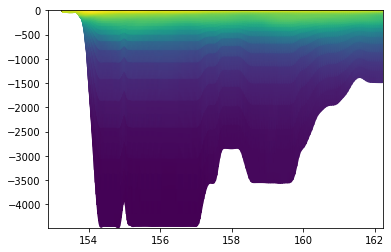

In [29]:
fig,ax=plt.subplots()
x=truth.lon_rho.isel(eta_rho=316)
y=truth.z_rho.isel(eta_rho=316).mean(dim='ocean_time')
z=truth.temp.isel(eta_rho=316).mean(dim='ocean_time')
ax.pcolormesh(x,y,z,shading='gouraud')

<Figure size 432x288 with 0 Axes>

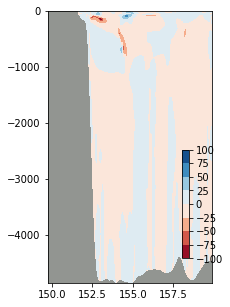

In [151]:
## test vertical transect

def addSubplot_VerticalTransect_contourf(X,Y,input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.contourf(X,Y,input,levels,**pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    return ax

gs = gridspec.GridSpec(nrows=1,ncols=3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

# add plots
## top row
levels=np.arange(-100,110,25)
ax15 = addSubplot_VerticalTransect_contourf(np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,levels,gs,0,0,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax1.plot(boxLon,boxDep,color='0.8')


In [149]:
import numpy.matlib
np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1).shape

(30, 272)

<Figure size 432x288 with 0 Axes>

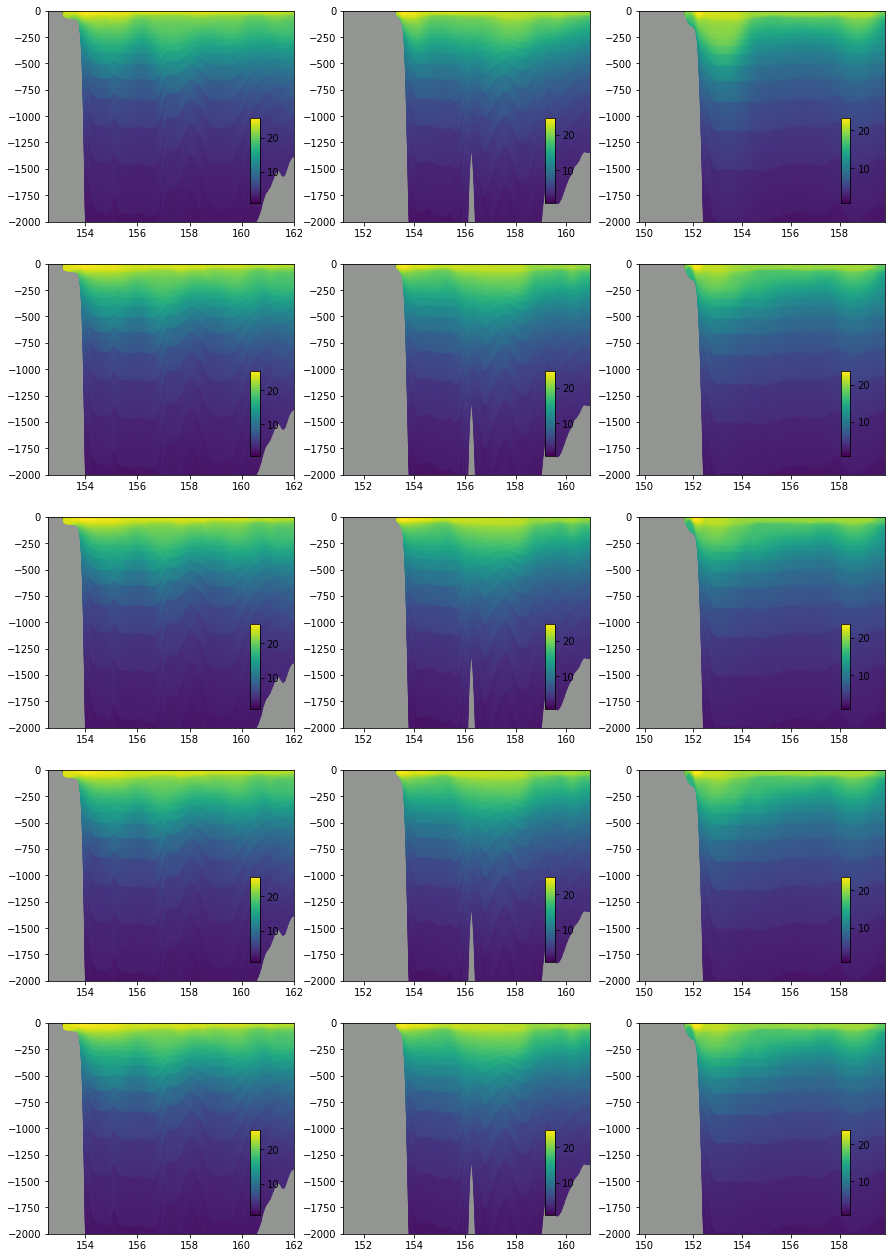

In [32]:
## test vertical transect

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud')
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    ax.set_ylim([-2000,0])
    fig.colorbar(im, cax=cax)
    return ax,im

gs = gridspec.GridSpec(nrows=5,ncols=3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,22.5])
ax = None

# add plots
## top row
etaTransect=300
z=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax1 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,0,0,'a')#, ax1[0].set_title('u (m/s)')
etaTransect=220
z=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax2 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,0,1,'b')#, ax1[0].set_title('u (m/s)')
etaTransect=140
z=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax3 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,0,2,'c')#, ax1[0].set_title('u (m/s)')
#row2
etaTransect=300
z=OSSE_SSHSST.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax4 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,1,0,'d')#, ax1[0].set_title('u (m/s)')
etaTransect=220
z=OSSE_SSHSST.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax5 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,1,1,'e')#, ax1[0].set_title('u (m/s)')
etaTransect=140
z=OSSE_SSHSST.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax6 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,1,2,'f')#, ax1[0].set_title('u (m/s)')
#row 3
etaTransect=300
z=OSSE_SSHSST_XBT_N.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax7 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,2,0,'g')#, ax1[0].set_title('u (m/s)')
etaTransect=220
z=OSSE_SSHSST_XBT_N.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax8 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,2,1,'h')#, ax1[0].set_title('u (m/s)')
etaTransect=140
z=OSSE_SSHSST_XBT_N.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax9 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,2,2,'i')#, ax1[0].set_title('u (m/s)')
#row 4
etaTransect=300
z=OSSE_SSHSST_XBT_S.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax10 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,3,0,'j')#, ax1[0].set_title('u (m/s)')
etaTransect=220
z=OSSE_SSHSST_XBT_S.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax11 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,3,1,'k')#, ax1[0].set_title('u (m/s)')
etaTransect=140
z=OSSE_SSHSST_XBT_S.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax12 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,3,2,'l')#, ax1[0].set_title('u (m/s)')
#row 5
etaTransect=300
z=OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax13 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,4,0,'m')#, ax1[0].set_title('u (m/s)')
etaTransect=220
z=OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax14 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,4,1,'n')#, ax1[0].set_title('u (m/s)')
etaTransect=140
z=OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
ax15 = addSubplot_VerticalTransect(truth.lon_rho.isel(eta_rho=etaTransect),truth.z_rho.isel(eta_rho=etaTransect).mean(dim='ocean_time'),z,gs,4,2,'o')#, ax1[0].set_title('u (m/s)')


<Figure size 432x288 with 0 Axes>

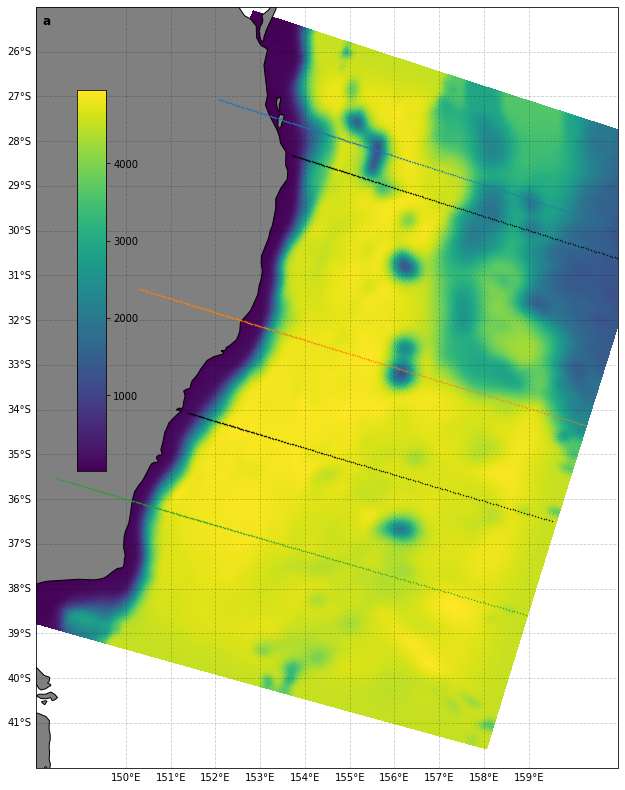

In [18]:

def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(150,160))
    gl.ylocator = mticker.FixedLocator(np.arange(-45,45))

    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
    ax.set_title('')
    return ax


gs = gridspec.GridSpec(nrows=1,ncols=1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[30,14])
ax = None

ax1 = spatialMap_addGSSubplot(OSSE_SSHSST.h,gs,0,0,'a')
transectEta=270
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)
transectEta=170
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C1",marker='.',markersize=1,zorder=12)
transectEta=70
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C2",marker='.',markersize=1,zorder=12)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax1.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax1.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)